## Syria-Tel Classification Modeling

## Business Understanding

Telecom company.  Trying to come up with a model that predicts churn based on customer location and usage data. 

## Data Understanding

#### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from pandas.api.types import is_numeric_dtype
from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

#### Functions and Constants

In [2]:
test_size = .35

#### Importing data

In [3]:
df = pd.read_csv('data/bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


#### Data exploration / cleaning

Review and fix the feature names to be more code friendly. 

In [4]:
# View column names
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [5]:
# Rename columns
df.columns = df.columns.str.replace(" ", "_")
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

Check out the features we have and if there are any null values.

In [6]:
df

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


Check out the values in each feature to see what type of data each really is.

In [7]:
for x in df.columns:
    print(df[x].value_counts())        

WV    106
MN     84
NY     83
AL     80
OR     78
WI     78
OH     78
WY     77
VA     77
CT     74
ID     73
MI     73
VT     73
UT     72
TX     72
IN     71
MD     70
KS     70
NC     68
MT     68
NJ     68
WA     66
NV     66
CO     66
MS     65
MA     65
RI     65
AZ     64
FL     63
MO     63
ME     62
ND     62
NM     62
NE     61
DE     61
OK     61
SC     60
SD     60
KY     59
IL     58
NH     56
AR     55
GA     54
DC     54
TN     53
HI     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: state, dtype: int64
105    43
87     42
93     40
101    40
90     39
       ..
191     1
199     1
215     1
221     1
2       1
Name: account_length, Length: 212, dtype: int64
415    1655
510     840
408     838
Name: area_code, dtype: int64
345-2863    1
406-2454    1
418-8257    1
379-3953    1
351-7309    1
           ..
361-1404    1
344-5973    1
375-9671    1
397-9184    1
369-6890    1
Name: phone_number, Length: 3333, dtype: int64
no     3010
yes     323
Name: internati

In [8]:
df.describe()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [9]:
df.isna().sum()

state                     0
account_length            0
area_code                 0
phone_number              0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64

## Data Preparation

#### Figure out feature types

In [10]:
X_numeric_cols = ['account_length','number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls']
X_categorical_cols = ['state', 'area_code','international_plan', 'voice_mail_plan']
X_ignore_cols = ['phone_number']
y_target_col = 'churn'

#### Train-test-split of the data

In [11]:
X = df.drop(X_ignore_cols + [y_target_col], axis=1)
y = df[y_target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=test_size)

In [12]:
df.churn.value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

This seems to be imbalanced.  Plan on using SMOTE to oversample the minority class later on. 

#### Create column transformer pipelines

In [13]:
# Numerical column transformers
num_pipe = Pipeline([('ss',StandardScaler())])

# Categorical column transformers
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])
CT = ColumnTransformer(transformers=[
    ('num_trans', num_pipe, X_numeric_cols),
    ('cat_trans', cat_pipe, X_categorical_cols)
],remainder='passthrough')

## Modeling

### Baseline Model

#### Dummy Classifier

In [14]:
model_name = "Baseline"
model = DummyClassifier(strategy='most_frequent', random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

Baseline:
CV score on training data (mean): 0.8555
Results on test data:             0.8543


### Round 1 - Simple Models (default hyperparameters)

#### Logistic Regression Classifier

In [15]:
model_name = "Logistic Regression"
model = LogisticRegression(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

Logistic Regression:
CV score on training data (mean): 0.8569
Results on test data:             0.8646


Results:
- The Logistic Regression Classifier did not improve the accuracy over the baseline model notably.
- Appears potentially underfit as the test data outperformed the training data.

#### Decision Tree Classifier

In [16]:
model_name = "Decision Tree Classifier"
model = DecisionTreeClassifier(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

Decision Tree Classifier:
CV score on training data (mean): 0.9031
Results on test data:             0.9186


Results:
- This model improved the accuracy over the baseline model by ~6%.  
- Appears potentially underfit as the test data outperformed the training data.

#### KNearestNeighbors Classifier

In [17]:
model_name = "KNearestNeighbors Classifier"
model = KNeighborsClassifier()
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

KNearestNeighbors Classifier:
CV score on training data (mean): 0.8818
Results on test data:             0.88


Results:
- The KNN model improved the accuracy over the baseline model by ~3%.
- The model does not appear notably underfit or overfit.

#### Random Forest Classifier

In [18]:
model_name = "Random Forest Classifier"
model = RandomForestClassifier(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

Random Forest Classifier:
CV score on training data (mean): 0.9381
Results on test data:             0.9383


Results:
- The Random Forest model improved the accuracy over the baseline model on test data by ~9%.  
- The model does not appear notably underfit or overfit.
- This is a top performing model.

#### GuassianNB Classifier

In [19]:
model_name = "GuassianNB Classifier"
model = GaussianNB()
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

GuassianNB Classifier:
CV score on training data (mean): 0.5527
Results on test data:             0.5758


Results:
- The Guassian NB model did not perform well. 

#### SVC Classifier

In [20]:
model_name = "SVC Classifier"
model = SVC(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

SVC Classifier:
CV score on training data (mean): 0.9017
Results on test data:             0.9109


Results:
- The SVC model improved the accuracy over the baseline model on test data by 4-5%.  
- Appears potentially underfit as the test data outperformed the training data.

#### Gradient Booster Classifier

In [21]:
model_name = "Gradient Booster"
model = GradientBoostingClassifier(random_state=42)
pipe = Pipeline([('ct', CT), 
                 ('model', model)])

results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

Gradient Booster:
CV score on training data (mean): 0.9451
Results on test data:             0.952


Results:
- The Gradient Booster Classifier improved the accuracy over the baseline model on test data by ~9%.  
- Appears potentially underfit as the test data outperformed the training data.
- This is a top performing model.

#### XGBoost Classifier

In [22]:
# Transform y-train and y-test based using LabelEncoder
# This is specific to XGBoost
encoder = LabelEncoder()
y_train_xgb = pd.Series(encoder.fit_transform(y_train))
y_test_xgb = pd.Series(encoder.transform(y_test))

model_name = "XGBoost Classifier"
model = XGBClassifier(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train_xgb, cv=10)
y_hat = pipe.fit(X_train, y_train_xgb).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test_xgb, y_hat), 4)}")

XGBoost Classifier:
CV score on training data (mean): 0.9529
Results on test data:             0.9529


Results:
- The XGBoost Classifier improved the accuracy over the baseline model on test data by ~10%.  
- It does not appear to be notably underfit or overfit. 
- This is a top performing model.

#### Conclusion from Round 1
- The XGBoost, Gradient Booster, and Random Forest classifiers performed the best on test data. 

### Round 2 - Simple Models with Balanced Data using SMOTE

As we can see below, the target classes are pretty unbalanced (86%/14%).  I'd like to balance these using SMOTE to see if we can get any better results with the simple models. 

In [23]:
y_train.value_counts()

False    1853
True      313
Name: churn, dtype: int64

In [24]:
y_train.value_counts(normalize=True)

False    0.855494
True     0.144506
Name: churn, dtype: float64

#### Baseline Model

In [25]:
model_name = "Baseline - Unbalanced"
model = DummyClassifier(strategy='most_frequent', random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

print("\n")

model_name = "Baseline - Balanced"
model = DummyClassifier(strategy='most_frequent', random_state=42)
pipe = ImPipeline([('ct',CT),
                 ('sm', SMOTE(sampling_strategy='auto', random_state=42)),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")


Baseline - Unbalanced:
CV score on training data (mean): 0.8555
Results on test data:             0.8543


Baseline - Balanced:
CV score on training data (mean): 0.8555
Results on test data:             0.8543


Results:
- Balancing the data did not change the results on the baseline model.  I'm not certain of the reason.  Moving on to see if balancing the data changes the results of the other models.  

#### Logistic Regression Classifier

In [26]:
model_name = "Logistic Regression Classifier - Unbalanced"
model = LogisticRegression(random_state=42, max_iter=1000)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

print("\n")

model_name = "Logistic Regression Classifier - Balanced"
model = LogisticRegression(random_state=42, max_iter=1000)
pipe = ImPipeline([('ct',CT),
                   ('sm', SMOTE(sampling_strategy='auto', random_state=42)),
                   ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")


Logistic Regression Classifier - Unbalanced:
CV score on training data (mean): 0.8569
Results on test data:             0.8646


Logistic Regression Classifier - Balanced:
CV score on training data (mean): 0.7576
Results on test data:             0.7661


Results:  
- Balancing the data decreased the accuracy of the model on test data.   

#### Decision Tree Classifier

In [27]:
model_name = "Decision Tree Classifier - Unbalanced"
model = DecisionTreeClassifier(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

print("\n")

model_name = "Decision Tree Classifier - Balanced"
model = DecisionTreeClassifier(random_state=42)
pipe = ImPipeline([('ct',CT),
                   ('sm', SMOTE(sampling_strategy='auto', random_state=42)),
                   ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

Decision Tree Classifier - Unbalanced:
CV score on training data (mean): 0.9031
Results on test data:             0.9186


Decision Tree Classifier - Balanced:
CV score on training data (mean): 0.8851
Results on test data:             0.9237


Results:
- Balancing the data slightly improved accuracy of the model on test data.   

#### KNearestNeighbors Classifier

In [28]:
model_name = "KNearestNeighbors Classifier - Unbalanced"
model = KNeighborsClassifier()
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

print("\n")

model_name = "KNearestNeighbors Classifier - Balanced"
model = KNeighborsClassifier()
pipe = ImPipeline([('ct',CT),
                   ('sm', SMOTE(sampling_strategy='auto', random_state=42)),
                   ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

KNearestNeighbors Classifier - Unbalanced:
CV score on training data (mean): 0.8818
Results on test data:             0.88


KNearestNeighbors Classifier - Balanced:
CV score on training data (mean): 0.7461
Results on test data:             0.7481


Results:
- Balancing the data decreased the accuracy of the model on test data.  

#### Random Forest Classifier

In [29]:
model_name = "Random Forest Classifier - Unbalanced"
model = RandomForestClassifier(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

print("\n")

model_name = "Random Forest Classifier - Balanced"
model = RandomForestClassifier(random_state=42)
pipe = ImPipeline([('ct',CT),
                   ('sm', SMOTE(sampling_strategy='auto', random_state=42)),
                   ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

Random Forest Classifier - Unbalanced:
CV score on training data (mean): 0.9381
Results on test data:             0.9383


Random Forest Classifier - Balanced:
CV score on training data (mean): 0.9349
Results on test data:             0.9383


Results:
- Balancing the data did not notably increase the accuracy of the model on test data.  

#### GuassianNB Classifier

In [30]:
model_name = "GuassianNB Classifier - Unbalanced"
model = GaussianNB()
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

print("\n")

model_name = "GuassianNB Classifier - Balanced"
model = GaussianNB()
pipe = ImPipeline([('ct',CT),
                   ('sm', SMOTE(sampling_strategy='auto', random_state=42)),
                   ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

GuassianNB Classifier - Unbalanced:
CV score on training data (mean): 0.5527
Results on test data:             0.5758


GuassianNB Classifier - Balanced:
CV score on training data (mean): 0.5513
Results on test data:             0.5527


Results:
- Balancing the data decreased the accuracy of the model on test data.   

#### SVC Classifier

In [31]:
model_name = "SVC Classifier - Unbalanced"
model = SVC(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

print("\n")

model_name = "SVC Classifier - Balanced"
model = SVC(random_state=42)
pipe = ImPipeline([('ct',CT),
                   ('sm', SMOTE(sampling_strategy='auto', random_state=42)),    
                   ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

SVC Classifier - Unbalanced:
CV score on training data (mean): 0.9017
Results on test data:             0.9109


SVC Classifier - Balanced:
CV score on training data (mean): 0.8915
Results on test data:             0.91


Results:
- Balancing the data decreased the accuracy of the model on test data.  

#### Gradient Booster Classifier

In [32]:
model_name = "Gradient Booster Classifier - Unbalanced"
model = GradientBoostingClassifier(random_state=42)
pipe = Pipeline([('ct', CT), 
                 ('model', model)
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

print("\n")

model_name = "Gradient Booster Classifier - Balanced"
model = GradientBoostingClassifier(random_state=42)
pipe = ImPipeline([('ct', CT), 
                   ('sm', SMOTE(sampling_strategy='auto', random_state=42)),
                   ('model', model)
])
results = cross_val_score(pipe, X_train, y_train, cv=10)
y_hat = pipe.fit(X_train, y_train).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test, y_hat), 4)}")

Gradient Booster Classifier - Unbalanced:
CV score on training data (mean): 0.9451
Results on test data:             0.952


Gradient Booster Classifier - Balanced:
CV score on training data (mean): 0.9321
Results on test data:             0.9374


Results:
- Balancing the data decreased the accuracy of the model on test data.

#### XGBoost Classifier

In [33]:
# Transform y-train and y-test based using LabelEncoder
# This is specific to XGBoost
encoder = LabelEncoder()
y_train_xgb = pd.Series(encoder.fit_transform(y_train))
y_test_xgb = pd.Series(encoder.transform(y_test))

model_name = "XGBoost Classifier - Unbalanced"
model = XGBClassifier(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train_xgb, cv=10)
y_hat = pipe.fit(X_train, y_train_xgb).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test_xgb, y_hat), 4)}")

print('\n')

model_name = "XGBoost Classifier - Balanced"
model = XGBClassifier(random_state=42)
pipe = ImPipeline([('ct',CT),
                   ('sm', SMOTE(sampling_strategy='auto', random_state=42)),
                   ('model', model) 
])
results = cross_val_score(pipe, X_train, y_train_xgb, cv=10)
y_hat = pipe.fit(X_train, y_train_xgb).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test_xgb, y_hat), 4)}")

XGBoost Classifier - Unbalanced:
CV score on training data (mean): 0.9529
Results on test data:             0.9529


XGBoost Classifier - Balanced:
CV score on training data (mean): 0.9511
Results on test data:             0.9572


Results:
- Balancing the data slightly improved the accuracy of the model on test data.  

#### Conclusion from Round 2
- Using SMOTE to balance the data did not notably improve any of the models performance, and in fact in decreased the performance of most of the models.  It appears that using data as is (86/14 split) is not that bad for the models.  This would align with the 90/10 split threshold discussed during our class.  As such, I will not use SMOTE going forward in the next round of modeling.  

### Round 3 - Gridsearch/Hyperparameter Tuning of the 3 Best Performing Models

#### XGBoost Classifier

In [34]:
# Transform y-train and y-test based using LabelEncoder
# This is specific to XGBoost
encoder = LabelEncoder()
y_train_xgb = pd.Series(encoder.fit_transform(y_train))
y_test_xgb = pd.Series(encoder.transform(y_test))

model_name = "XGBoost Classifier"
model = XGBClassifier(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])

Round 1 of Gridsearching on XGBoost Classifier (try parameters to the left and right of defaults)

In [35]:
parameters = {'model__learning_rate':[.1, .3, .5],          # default is 0.3 
              'model__max_depth': [4, 6, 8],                # default is 6    
              'model__min_child_weight': [0, 1, 2],         # default is 1    
              'model__subsample': [.75, 1.0]                # default is 1   
             }
gs = GridSearchCV(estimator=pipe,param_grid=parameters, cv=10, verbose=1)
gs.fit(X_train, y_train_xgb)
print(model_name + ": Round 1 of Gridsearching")
print("Best params:", gs.best_params_)
print("Best score:", gs.best_score_)
print("Score on test data:", gs.best_estimator_.score(X_test, y_test_xgb))

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  1.8min finished


XGBoost Classifier: Round 1 of Gridsearching
Best params: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__min_child_weight': 1, 'model__subsample': 0.75}
Best score: 0.9556835637480801
Score on test data: 0.9554413024850043


Results:
- Best params: {'model__learning_rate': 0.3, 'model__max_depth': 8, 'model__min_child_weight': 1, 'model__subsample': 1.0}
- Best score: 0.9579823293172691
- Score on test data: 0.9556354916067147

Round 2 of Gridsearching on XGBoost Classifer (use results of last gridsearch to narrow search)

In [36]:
parameters = {'model__learning_rate':[.25, .3, .35],            
              'model__max_depth': [8, 10, 12],                 
              'model__min_child_weight': [.5, 1, 1.5],      
              'model__subsample': [.8, .9, 1.0]                 
             }
gs = GridSearchCV(estimator=pipe,param_grid=parameters, cv=10, verbose=1)
gs.fit(X_train, y_train_xgb)
print(model_name + " - Round 2 of Gridsearching:")
print("Best params:", gs.best_params_)
print("Best score:", gs.best_score_)
print("Score on test data:", gs.best_estimator_.score(X_test, y_test_xgb))

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:  3.3min finished


XGBoost Classifier - Round 2 of Gridsearching:
Best params: {'model__learning_rate': 0.25, 'model__max_depth': 8, 'model__min_child_weight': 0.5, 'model__subsample': 1.0}
Best score: 0.9570767195767196
Score on test data: 0.9554413024850043


Results:
- Best params: {'model__learning_rate': 0.25, 'model__max_depth': 10, 'model__min_child_weight': 1, 'model__subsample': 0.9}
- Best score: 0.959182329317269
- Score on test data: 0.9496402877697842

Round 3 of Gridsearching on XGBoost Classifer (use results of last gridsearch to narrow search)

In [37]:
parameters = {'model__learning_rate':[.15, .20, .25],            
              'model__max_depth': [9, 10, 11],                 
              'model__min_child_weight': [.9, 1, 1.1],      
              'model__subsample': [.92, .935, .95]                 
             }
gs = GridSearchCV(estimator=pipe,param_grid=parameters, cv=10, verbose=1)
gs.fit(X_train, y_train_xgb)
print(model_name + " - Round 4 of Gridsearching:")
print("Best params:", gs.best_params_)
print("Best score:", gs.best_score_)
print("Score on test data:", gs.best_estimator_.score(X_test, y_test_xgb))

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:  3.6min finished


XGBoost Classifier - Round 4 of Gridsearching:
Best params: {'model__learning_rate': 0.15, 'model__max_depth': 9, 'model__min_child_weight': 0.9, 'model__subsample': 0.95}
Best score: 0.9584634749957331
Score on test data: 0.9502999143101971


Results:
- Best params: {'model__learning_rate': 0.15, 'model__max_depth': 11, 'model__min_child_weight': 0.9, 'model__subsample': 0.95}
- Best score: 0.9599839357429719
- Score on test data: 0.9508393285371702

Round 4 of Gridsearching on XGBoost Classifer (use results of last gridsearch to narrow search)

In [38]:
parameters = {'model__learning_rate':[.145, .15, .155],            
              'model__max_depth': [10.5, 10.75, 11],                 
              'model__min_child_weight': [.85, .9, .95],      
              'model__subsample': [.85, .9, .95]                 
             }
gs = GridSearchCV(estimator=pipe,param_grid=parameters, cv=10, verbose=1)
gs.fit(X_train, y_train_xgb)
print(model_name + " - Round 4 of Gridsearching:")
print("Best params:", gs.best_params_)
print("Best score:", gs.best_score_)
print("Score on test data:", gs.best_estimator_.score(X_test, y_test_xgb))

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, d

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 828, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\xgboost\

XGBoost Classifier - Round 4 of Gridsearching:
Best params: {'model__learning_rate': 0.15, 'model__max_depth': 11, 'model__min_child_weight': 0.9, 'model__subsample': 0.9}
Best score: 0.9566180235535076
Score on test data: 0.9520137103684662


Results:
- Best params: {'model__learning_rate': 0.15, 'model__max_depth': 11, 'model__min_child_weight': 0.9, 'model__subsample': 0.95}
- Best score: 0.9599839357429719
- Score on test data: 0.9508393285371702

#### Gradient Booster Classifier

Round 1 of Gridsearching on Gradient Booster Classifier (try parameters to the left and right of defaults)

In [39]:
model_name = "Gradient Booster"
model = GradientBoostingClassifier(random_state=42)
pipe = Pipeline([('ct', CT), 
                 ('model', model)])

In [40]:
parameters = {#'model__loss':['log_loss', 'deviance'],               # default is log_loss  
              'model__n_estimators':[100, 200],                      # default is 100
              'model__learning_rate':[.1, .3],                       # default is 0.1 
              'model__max_depth': [5, 7],                            # default is 3 
              'model__criterion': ['friedman_mse','squared_error'],  # default is friedman_mse
              'model__subsample': [.8, 1.0]                          # default is 1   
             }
gs = GridSearchCV(estimator=pipe,param_grid=parameters, cv=10, verbose=2)
gs.fit(X_train, y_train)
print(model_name + ": Round 1 of Gridsearching")
print("Best params:", gs.best_params_)
print("Best score:", gs.best_score_)
print("Score on test data:", gs.best_estimator_.score(X_test, y_test))

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8, total=   1.1s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8, total=   0.8s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8, total=   0.8s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8, total=   0.8s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8, total=   0.9s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0, total=   1.9s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0, total=   1.9s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0, total=   2.0s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0, total=   2.0s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8, total=   2.9s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8, total=   2.4s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8, total=   2.2s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8, total=   2.2s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0, total=   1.2s
[CV] model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0, total=   1.2s
[CV] model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0, total=   1.2s
[CV] model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0, total=   1.2s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8, total=   1.4s
[CV] model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8, total=   1.5s
[CV] model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8, total=   1.1s
[CV] model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8, total=   1.1s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=1.0, total=   2.7s
[CV] model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=1.0, total=   2.7s
[CV] model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=1.0, total=   2.7s
[CV] model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=1.0, total=   2.6s
[CV] model__criterion=squared_error, 

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_

[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_

[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_

[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_

[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_

[CV]  model__criterion=squared_error, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=200, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_

[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=100, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_

[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=200, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=200, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=200, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=5, model__n_estimators=200, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_

[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_

[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=0.8, total=   0.0s
[CV] model__criterion=squared_

C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_

[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=1.0, total=   0.0s
[CV] model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=1.0 
[CV]  model__criterion=squared_error, model__learning_rate=0.3, model__max_depth=7, model__n_estimators=200, model__subsample=1.0, total=   0.0s


C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_

Gradient Booster: Round 1 of Gridsearching
Best params: {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__subsample': 0.8}
Best score: 0.9519947943335041
Score on test data: 0.9528706083976007


Results:
- Best params: {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}
- Best score: 0.9555823293172689
- Score on test data: 0.9532374100719424

Round 2 of Gridsearching on Gradient Booster Classifier (adjusted from prior gridsearch)

In [41]:
parameters = {#'model__loss':['log_loss', 'deviance'],               # default is log_loss  
              'model__n_estimators':[200, 300],                      # default is 100
              'model__learning_rate':[.1, .2],                       # default is 0.1 
              'model__max_depth': [4, 5, 6],                            # default is 3 
              'model__criterion': ['friedman_mse'],  # default is friedman_mse
              'model__subsample': [.7, .8, .9]                          # default is 1   
             }
gs = GridSearchCV(estimator=pipe,param_grid=parameters, cv=10, verbose=2)
gs.fit(X_train, y_train)
print(model_name + ": Round 2 of Gridsearching")
print("Best params:", gs.best_params_)
print("Best score:", gs.best_score_)
print("Score on test data:", gs.best_estimator_.score(X_test, y_test))

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=200, model__subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=200, model__subsample=0.7, total=   1.3s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=200, model__subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=200, model__subsample=0.7, total=   1.2s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=200, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=200, model__subsample=0.7, total=   1.2s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=200, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=200, model__subsample=0.7, total=   1.1s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=200, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=200, model__subsample=0.7, total=   1.2s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=300, model__subsample=0.7, total=   1.8s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=300, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=300, model__subsample=0.7, total=   1.7s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=300, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=300, model__subsample=0.7, total=   2.1s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=300, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=300, model__subsample=0.7, total=   2.0s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=0.7, total=   1.4s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=0.7, total=   1.5s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=0.7, total=   1.5s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=0.7, total=   1.5s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300, model__subsample=0.7, total=   2.1s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300, model__subsample=0.7, total=   2.3s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300, model__subsample=0.7, total=   2.6s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300, model__subsample=0.7, total=   2.6s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.7, total=   1.7s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.7, total=   1.7s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.7, total=   1.7s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.7, total=   1.7s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=300, model__subsample=0.7, total=   2.5s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=300, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=300, model__subsample=0.7, total=   2.5s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=300, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=300, model__subsample=0.7, total=   2.5s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=300, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=300, model__subsample=0.7, total=   2.5s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=200, model__subsample=0.7, total=   1.1s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=200, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=200, model__subsample=0.7, total=   1.1s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=200, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=200, model__subsample=0.7, total=   1.1s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=200, model__subsample=0.8, total=   1.2s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=300, model__subsample=0.7, total=   1.7s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=300, model__subsample=0.7 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=300, model__subsample=0.7, total=   1.7s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=300, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=300, model__subsample=0.8, total=   1.9s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=300, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=300, model__subsample=0.8, total=   1.8s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=200, model__subsample=0.7, total=   1.4s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=200, model__subsample=0.8, total=   1.5s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=200, model__subsample=0.8, total=   1.7s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=200, model__subsample=0.8, total=   1.6s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300, model__subsample=0.8, total=   2.7s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300, model__subsample=0.8, total=   2.5s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300, model__subsample=0.8, total=   2.3s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=5, model__n_estimators=300, model__subsample=0.8, total=   2.3s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=200, model__subsample=0.8, total=   1.8s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=200, model__subsample=0.8, total=   1.8s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=200, model__subsample=0.8, total=   1.8s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=200, model__subsample=0.8, total=   1.8s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=300, model__subsample=0.8, total=   2.8s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=300, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=300, model__subsample=0.8, total=   2.8s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=300, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=300, model__subsample=0.8, total=   2.8s
[CV] model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=300, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.2, model__max_depth=6, model__n_estimators=300, model__subsample=0.8, total=   2.8s
[CV] model__criterion=friedman_mse, m

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 11.9min finished


Gradient Booster: Round 2 of Gridsearching
Best params: {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__subsample': 0.7}
Best score: 0.9552270011947431
Score on test data: 0.9520137103684662


Results:
- Best params: {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 300, 'model__subsample': 0.8}
- Best score: 0.9559839357429718
- Score on test data: 0.9532374100719424

Round 3 of Gridsearching on Gradient Booster Classifier (adjusted from prior gridsearch)

In [42]:
parameters = {'model__n_estimators':[200],                       # default is 100
              'model__learning_rate':[.1],                       # default is 0.1 
              'model__max_depth': [6, 8, 10, 12],                # default is 3 
              'model__criterion': ['friedman_mse'],              # default is friedman_mse
              'model__subsample': [.8]                           # default is 1   
             }
gs = GridSearchCV(estimator=pipe,param_grid=parameters, cv=10, verbose=2)
gs.fit(X_train, y_train)
print(model_name + ": Round 2 of Gridsearching")
print("Best params:", gs.best_params_)
print("Best score:", gs.best_score_)
print("Score on test data:", gs.best_estimator_.score(X_test, y_test))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.8, total=   1.9s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.8, total=   1.9s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.8, total=   1.9s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.8, total=   1.9s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsample=0.8, total=   1.9s
[CV] model__criterion=friedman_mse, m

[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=12, model__n_estimators=200, model__subsample=0.8, total=   4.0s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=12, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=12, model__n_estimators=200, model__subsample=0.8, total=   4.0s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=12, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=12, model__n_estimators=200, model__subsample=0.8, total=   4.0s
[CV] model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=12, model__n_estimators=200, model__subsample=0.8 
[CV]  model__criterion=friedman_mse, model__learning_rate=0.1, model__max_depth=12, model__n_estimators=200, model__subsample=0.8, total=   4.0s
[CV] model__criterion=friedman

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.0min finished


Gradient Booster: Round 2 of Gridsearching
Best params: {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.1, 'model__max_depth': 12, 'model__n_estimators': 200, 'model__subsample': 0.8}
Best score: 0.9543010752688174
Score on test data: 0.9511568123393316


Results:
- Best params: {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__subsample': 0.8}
- Best score: 0.9547839357429719
- Score on test data: 0.9496402877697842

#### Random Forest Classifier

In [43]:
model_name = "Random Forest Classifier"
model = RandomForestClassifier(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])

Round 1 of Gridsearching on Random Forest Classifier (try parameters to the left and right of defaults)

In [44]:
parameters = {'model__n_estimators':[50, 100, 200],                       # default is 100
              'model__max_depth': [None, 3, 6, 9],                          # default is None
              'model__criterion': ['gini', 'entropy'],                # default is gini
              'model__min_samples_split': [1.0, 3, 5]                          # default is 1
             }
gs = GridSearchCV(estimator=pipe,param_grid=parameters, cv=10, verbose=2)
gs.fit(X_train, y_train)
print(model_name + ": Round 1 of Gridsearching")
print("Best params:", gs.best_params_)
print("Best score:", gs.best_score_)
print("Score on test data:", gs.best_estimator_.score(X_test, y_test))

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=50, total=   0.0s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=1.0, model__n_estimator

[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=3, model__n_estimators=50, total=   0.2s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=3, model__n_estimators=100, total=   0.3s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=3, model__n_estimators=100, total=   0.3s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=3, model__n_estimators=100, total=   0.3s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=3, model__n_estimators=100, tota

[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=5, model__n_estimators=100, total=   0.3s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=5, model__n_estimators=100, total=   0.3s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=5, model__n_estimators=100, total=   0.3s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=5, model__n_estimators=100, total=   0.3s
[CV] model__criterion=gini, model__max_depth=None, model__min_samples_split=5, model__n_estimators=200 
[CV]  model__criterion=gini, model__max_depth=None, model__min_samples_split=5, model__n_estimators=200, tot

[CV]  model__criterion=gini, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=200, total=   0.2s
[CV] model__criterion=gini, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=200 
[CV]  model__criterion=gini, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=200, total=   0.2s
[CV] model__criterion=gini, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=200 
[CV]  model__criterion=gini, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=200, total=   0.2s
[CV] model__criterion=gini, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=200 
[CV]  model__criterion=gini, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=200, total=   0.2s
[CV] model__criterion=gini, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=200 
[CV]  model__criterion=gini, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=200, total=   0.2

[CV]  model__criterion=gini, model__max_depth=3, model__min_samples_split=5, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gini, model__max_depth=3, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=3, model__min_samples_split=5, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gini, model__max_depth=3, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=3, model__min_samples_split=5, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gini, model__max_depth=3, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=3, model__min_samples_split=5, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gini, model__max_depth=3, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=3, model__min_samples_split=5, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gin

[CV]  model__criterion=gini, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=100, total=   0.1s
[CV] model__criterion=gini, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=100, total=   0.1s
[CV] model__criterion=gini, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=100, total=   0.1s
[CV] model__criterion=gini, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=100, total=   0.1s
[CV] model__criterion=gini, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=100, total=   0.1

[CV]  model__criterion=gini, model__max_depth=6, model__min_samples_split=3, model__n_estimators=100, total=   0.2s
[CV] model__criterion=gini, model__max_depth=6, model__min_samples_split=3, model__n_estimators=200 
[CV]  model__criterion=gini, model__max_depth=6, model__min_samples_split=3, model__n_estimators=200, total=   0.4s
[CV] model__criterion=gini, model__max_depth=6, model__min_samples_split=3, model__n_estimators=200 
[CV]  model__criterion=gini, model__max_depth=6, model__min_samples_split=3, model__n_estimators=200, total=   0.4s
[CV] model__criterion=gini, model__max_depth=6, model__min_samples_split=3, model__n_estimators=200 
[CV]  model__criterion=gini, model__max_depth=6, model__min_samples_split=3, model__n_estimators=200, total=   0.4s
[CV] model__criterion=gini, model__max_depth=6, model__min_samples_split=3, model__n_estimators=200 
[CV]  model__criterion=gini, model__max_depth=6, model__min_samples_split=3, model__n_estimators=200, total=   0.4s
[CV] model__crit

[CV]  model__criterion=gini, model__max_depth=6, model__min_samples_split=5, model__n_estimators=200, total=   0.4s
[CV] model__criterion=gini, model__max_depth=6, model__min_samples_split=5, model__n_estimators=200 
[CV]  model__criterion=gini, model__max_depth=6, model__min_samples_split=5, model__n_estimators=200, total=   0.4s
[CV] model__criterion=gini, model__max_depth=6, model__min_samples_split=5, model__n_estimators=200 
[CV]  model__criterion=gini, model__max_depth=6, model__min_samples_split=5, model__n_estimators=200, total=   0.4s
[CV] model__criterion=gini, model__max_depth=9, model__min_samples_split=1.0, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=9, model__min_samples_split=1.0, model__n_estimators=50, total=   0.0s
[CV] model__criterion=gini, model__max_depth=9, model__min_samples_split=1.0, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=9, model__min_samples_split=1.0, model__n_estimators=50, total=   0.1s
[CV] model__

[CV]  model__criterion=gini, model__max_depth=9, model__min_samples_split=3, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gini, model__max_depth=9, model__min_samples_split=3, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=9, model__min_samples_split=3, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gini, model__max_depth=9, model__min_samples_split=3, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=9, model__min_samples_split=3, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gini, model__max_depth=9, model__min_samples_split=3, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=9, model__min_samples_split=3, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gini, model__max_depth=9, model__min_samples_split=3, model__n_estimators=50 
[CV]  model__criterion=gini, model__max_depth=9, model__min_samples_split=3, model__n_estimators=50, total=   0.1s
[CV] model__criterion=gin

[CV]  model__criterion=gini, model__max_depth=9, model__min_samples_split=5, model__n_estimators=100, total=   0.2s
[CV] model__criterion=gini, model__max_depth=9, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=9, model__min_samples_split=5, model__n_estimators=100, total=   0.2s
[CV] model__criterion=gini, model__max_depth=9, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=9, model__min_samples_split=5, model__n_estimators=100, total=   0.2s
[CV] model__criterion=gini, model__max_depth=9, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=9, model__min_samples_split=5, model__n_estimators=100, total=   0.2s
[CV] model__criterion=gini, model__max_depth=9, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=gini, model__max_depth=9, model__min_samples_split=5, model__n_estimators=100, total=   0.2s
[CV] model__crit

[CV]  model__criterion=entropy, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=200, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=200, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=200, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=200, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=None, model__min_samples_split=1.0, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=None, model__min_sa

[CV]  model__criterion=entropy, model__max_depth=None, model__min_samples_split=3, model__n_estimators=200, total=   0.6s
[CV] model__criterion=entropy, model__max_depth=None, model__min_samples_split=3, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=None, model__min_samples_split=3, model__n_estimators=200, total=   0.6s
[CV] model__criterion=entropy, model__max_depth=None, model__min_samples_split=3, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=None, model__min_samples_split=3, model__n_estimators=200, total=   0.6s
[CV] model__criterion=entropy, model__max_depth=None, model__min_samples_split=3, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=None, model__min_samples_split=3, model__n_estimators=200, total=   0.6s
[CV] model__criterion=entropy, model__max_depth=None, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=entropy, model__max_depth=None, model__min_samples_split=5, mo

[CV] model__criterion=entropy, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=50 
[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=50, total=   0.1s
[CV] model__criterion=entropy, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=50 
[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=50, total=   0.1s
[CV] model__criterion=entropy, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=50 
[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=50, total=   0.0s
[CV] model__criterion=entropy, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=50 
[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators=50, total=   0.1s
[CV] model__criterion=entropy, model__max_depth=3, model__min_samples_split=1.0, model__n_estimators

[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=3, model__n_estimators=100, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=3, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=3, model__n_estimators=100, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=3, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=3, model__n_estimators=100, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=3, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=3, model__n_estimators=100, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=3, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=3, model__n_estimators=100, tot

[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=5, model__n_estimators=100, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=3, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=5, model__n_estimators=100, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=3, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=5, model__n_estimators=100, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=3, model__min_samples_split=5, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=5, model__n_estimators=200, total=   0.3s
[CV] model__criterion=entropy, model__max_depth=3, model__min_samples_split=5, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=3, model__min_samples_split=5, model__n_estimators=200, tot

[CV]  model__criterion=entropy, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=200, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=200, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=200, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=200, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=6, model__min_samples_split=1.0, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=6, model__min_samples_split=1.0, model__n_e

[CV]  model__criterion=entropy, model__max_depth=6, model__min_samples_split=5, model__n_estimators=50, total=   0.1s
[CV] model__criterion=entropy, model__max_depth=6, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=entropy, model__max_depth=6, model__min_samples_split=5, model__n_estimators=50, total=   0.1s
[CV] model__criterion=entropy, model__max_depth=6, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=entropy, model__max_depth=6, model__min_samples_split=5, model__n_estimators=50, total=   0.1s
[CV] model__criterion=entropy, model__max_depth=6, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=entropy, model__max_depth=6, model__min_samples_split=5, model__n_estimators=50, total=   0.1s
[CV] model__criterion=entropy, model__max_depth=6, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=entropy, model__max_depth=6, model__min_samples_split=5, model__n_estimators=50, total=   0.1

[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=1.0, model__n_estimators=50, total=   0.1s
[CV] model__criterion=entropy, model__max_depth=9, model__min_samples_split=1.0, model__n_estimators=100 
[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=1.0, model__n_estimators=100, total=   0.1s
[CV] model__criterion=entropy, model__max_depth=9, model__min_samples_split=1.0, model__n_estimators=100 
[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=1.0, model__n_estimators=100, total=   0.1s
[CV] model__criterion=entropy, model__max_depth=9, model__min_samples_split=1.0, model__n_estimators=100 
[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=1.0, model__n_estimators=100, total=   0.1s
[CV] model__criterion=entropy, model__max_depth=9, model__min_samples_split=1.0, model__n_estimators=100 
[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=1.0, model__n_es

[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=3, model__n_estimators=100, total=   0.3s
[CV] model__criterion=entropy, model__max_depth=9, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=3, model__n_estimators=100, total=   0.3s
[CV] model__criterion=entropy, model__max_depth=9, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=3, model__n_estimators=100, total=   0.3s
[CV] model__criterion=entropy, model__max_depth=9, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=3, model__n_estimators=100, total=   0.2s
[CV] model__criterion=entropy, model__max_depth=9, model__min_samples_split=3, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=3, model__n_estimators=200, tot

[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=5, model__n_estimators=200, total=   0.5s
[CV] model__criterion=entropy, model__max_depth=9, model__min_samples_split=5, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=5, model__n_estimators=200, total=   0.5s
[CV] model__criterion=entropy, model__max_depth=9, model__min_samples_split=5, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=5, model__n_estimators=200, total=   0.5s
[CV] model__criterion=entropy, model__max_depth=9, model__min_samples_split=5, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=5, model__n_estimators=200, total=   0.5s
[CV] model__criterion=entropy, model__max_depth=9, model__min_samples_split=5, model__n_estimators=200 
[CV]  model__criterion=entropy, model__max_depth=9, model__min_samples_split=5, model__n_estimators=200, tot

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  2.7min finished


Random Forest Classifier: Round 1 of Gridsearching
Best params: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_split': 3, 'model__n_estimators': 100}
Best score: 0.9395331967912612
Score on test data: 0.9443016281062554


Results:
- Best params: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_split': 3, 'model__n_estimators': 100}
- Best score: 0.9435775100401604
- Score on test data: 0.9484412470023981

#### Conclusion from Round 3
- XGBoost was the model with the best accuracy on test data using gridsearching.

### Best Model

#### XGBoost (Best Hyperparameters from Gridsearch)

XGBoost Classifier:
CV score on training data (mean): 0.9529
Results on test data:             0.9572


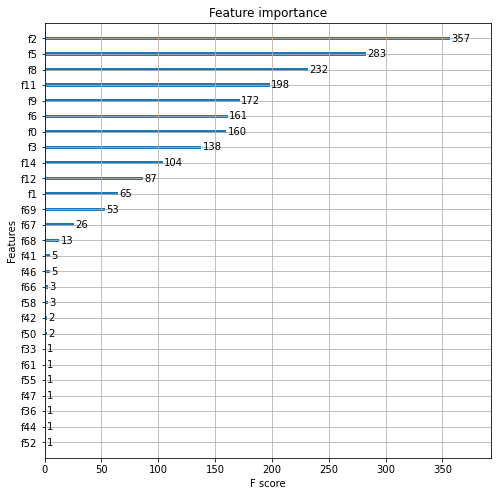

In [45]:
# Transform y-train and y-test based using LabelEncoder
# This is specific to XGBoost
encoder = LabelEncoder()
y_train_xgb = pd.Series(encoder.fit_transform(y_train))
y_test_xgb = pd.Series(encoder.transform(y_test))

model_name = "XGBoost Classifier"
model = XGBClassifier(random_state=42, learning_rate=.3, max_depth=8, min_child_weight=1, subsample=1.0)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])

results = cross_val_score(pipe, X_train, y_train_xgb, cv=10)
y_hat = pipe.fit(X_train, y_train_xgb).predict(X_test)
print(model_name + ":")
print(f"CV score on training data (mean): {round(np.mean(results), 4)}")
print(f"Results on test data:             {round(accuracy_score(y_test_xgb, y_hat), 4)}")

# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(8,8))
# plot feature importance
plot_importance(model, ax=ax)
pyplot.show()

## Evaluation

## Conclusion